# DCGAN

## Imports

In [0]:
import numpy as np
import itertools
import time
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle
import pdb
from tensorflow.examples.tutorials.mnist import input_data
from google.colab import files
import warnings

## Load data

In [4]:
IMAGE_SIZE = 28

tf.reset_default_graph()

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True, reshape=[])
X_train = mnist.train.images
X_train = (X_train - 0.5) / 0.5   

def leaky_relu(X, leak=0.2):
    f1 = 0.5 * (1 + leak)
    f2 = 0.5 * (1 - leak)
    return f1 * X + f2 * tf.abs(X)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


## Placeholder

In [0]:
x = tf.placeholder(tf.float32, shape=(None, IMAGE_SIZE, IMAGE_SIZE, 1))
noise = tf.placeholder(tf.float32, shape=(None, 1, 1, 100))
Training = tf.placeholder(dtype=tf.bool)
keep_prob = tf.placeholder(dtype=tf.float32, name='keep_prob')

## Generator

In [0]:
def Generator(x, keep_prob=keep_prob, Training=True, reuse=False):
    with tf.variable_scope('Generator', reuse=reuse):
        
        W = tf.truncated_normal_initializer(mean=0.0, stddev=0.02)
        b = tf.constant_initializer(0.0)
        g_init = tf.random_normal_initializer(1., 0.2)
        
        out_1 = tf.layers.conv2d_transpose(x, 256, [7, 7], strides=(1, 1), padding='valid', kernel_initializer=W, bias_initializer=b)
        out_1 = tf.layers.dropout(out_1, keep_prob)
        out_1 = tf.contrib.gan.features.VBN(out_1, gamma_initializer=g_init)(out_1)
        out_1 = leaky_relu(out_1, 0.2)
        
        out_2 = tf.layers.conv2d_transpose(out_1, 128, [5, 5], strides=(2, 2), padding='same', kernel_initializer=W, bias_initializer=b)
        out_2 = tf.layers.dropout(out_2, keep_prob)
        out_2 = tf.contrib.gan.features.VBN(out_2, gamma_initializer=g_init)(out_2)
        out_2 = leaky_relu(out_2, 0.2)
        
        out_3 = tf.layers.conv2d_transpose(out_2, 1, [5, 5], strides=(2, 2), padding='same', kernel_initializer=W, bias_initializer=b)
        out_3 = tf.nn.tanh(out_3)
        return out_3

## Discriminator

In [0]:
def Discriminator(x, keep_prob=keep_prob, Training=True, reuse=False):
    with tf.variable_scope('Discriminator', reuse=reuse):

        W = tf.truncated_normal_initializer(mean=0.0, stddev=0.02)
        b = tf.constant_initializer(0.0)
        d_init = tf.random_normal_initializer(1., 0.2)

        out_1 = tf.layers.conv2d(x, 128, [5, 5], strides=(2, 2), padding='same', kernel_initializer=W, bias_initializer=b)
        out_1 = tf.layers.dropout(out_1, keep_prob)
        out_1 = tf.contrib.gan.features.VBN(out_1, gamma_initializer=d_init)(out_1)
        out_1 = leaky_relu(out_1, 0.2)

        out_2 = tf.layers.conv2d(out_1, 256, [5, 5], strides=(2, 2), padding='same', kernel_initializer=W, bias_initializer=b)
        out_2 = tf.layers.dropout(out_2, keep_prob)
        out_2 = tf.contrib.gan.features.VBN(out_2, gamma_initializer=d_init)(out_2)
        out_2 = leaky_relu(out_2, 0.2)
        
        logits = tf.layers.conv2d(out_2, 1, [7, 7], strides=(1, 1), padding='valid', kernel_initializer=W, bias_initializer=b)
        out_3  = tf.nn.sigmoid(logits)
        return out_3 ,logits

## Parameters

In [0]:
EPOCH = 20
BATCH_SIZE = 200
keep_prob_train = 0.6
BETA1 = 0.5
lr = 0.0002
label_smooth = 1

## Loss function

In [9]:
# Generate images
G_noise = Generator(noise, keep_prob, Training)
# D
D_real, D_real_logits = Discriminator(x, Training)
D_fake, D_fake_logits = Discriminator(G_noise, Training, reuse=True)
# D real loss
Dis_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real_logits, labels=tf.multiply(tf.ones_like(D_real_logits), (label_smooth))))
# D generated image loss
Dis_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.zeros([BATCH_SIZE, 1, 1, 1])))
# D total loss
Dis_loss = Dis_loss_real + Dis_loss_fake
# G loss
Gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.ones([BATCH_SIZE, 1, 1, 1])))
# get all variables
tf_vars = tf.trainable_variables()
Dis_vars = [var for var in tf_vars if var.name.startswith('Discriminator')]
Gen_vars = [var for var in tf_vars if var.name.startswith('Generator')]
# optimise
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    D_optim = tf.train.AdamOptimizer(lr, beta1=BETA1).minimize(Dis_loss, var_list=Dis_vars)
    G_optim = tf.train.AdamOptimizer(lr, beta1=BETA1).minimize(Gen_loss, var_list=Gen_vars)

Instructions for updating:
Use keras.layers.conv2d_transpose instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Use tf.cast instead.


## Training

In [10]:
saver = tf.train.Saver()
num_examples = len(X_train) 
k = num_examples % BATCH_SIZE
num_examples = num_examples - k
G_loss = []
D_loss = []

D_r = []
D_f = []

    
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(EPOCH):  
        start = time.time()        
        X_train = shuffle(X_train)      
        for offset in range(0, num_examples, BATCH_SIZE):
            train_d = True
            train_g = True                        
            end = offset + BATCH_SIZE
            batch = X_train[offset:end] 
            noise_ = np.random.normal(0, 1, (BATCH_SIZE, 1, 1, 100))
                        
            #calculate loss
            d_ls = sess.run(Dis_loss,{noise: noise_, x: batch, Training: False})
            g_ls = sess.run(Gen_loss,{noise: noise_, x: batch, Training: False})
                                    
            #Gobal loss
           # d_ls_real, d_ls_fake = sess.run([Dis_loss_real, Dis_loss_fake], {noise: noise_,x: batch, Training: False})
            
            d_r = sess.run([D_real], {x: batch, Training: False})  
            d_f = sess.run([D_fake], {noise: noise_, Training: False}) 
            
            d_r = np.mean(d_r)
            d_f = np.mean(d_f)
            #break
            D_r.append(d_r)
            D_f.append(d_f)
                  
            D_loss.append(d_ls)
            G_loss.append(g_ls)
            
            if g_ls * 2 < d_ls:
                train_g = False
                pass
            if d_ls * 2 < g_ls:
                train_d = False
                pass
            
            #Update D 
            if train_d:
                sess.run(D_optim, {x: batch, noise: noise_,keep_prob: keep_prob_train,Training: True})
            
            #Update G
            if train_g:
                sess.run(G_optim, {noise: noise_, x: batch,keep_prob: keep_prob_train, Training: True})
                
        end = time.time()
        elapsed = end - start
        #break
        if ((i+1)%2 == 0)or(i==0):
            print("EPOCH {} ...".format(i+1))
            print("G_loss = {:.3f}  D_loss = {:.3f}  Time used = {:.3f}".format(g_ls, d_ls,elapsed))
            print()
    saver.save(sess, './lenet')
    print("Model saved")

EPOCH 1 ...
G_loss = 1.767  D_loss = 0.845  Time used = 113.370

EPOCH 2 ...
G_loss = 1.042  D_loss = 0.782  Time used = 107.270

EPOCH 4 ...
G_loss = 0.373  D_loss = 1.422  Time used = 115.721

EPOCH 6 ...
G_loss = 0.850  D_loss = 0.842  Time used = 118.628

EPOCH 8 ...
G_loss = 1.247  D_loss = 0.807  Time used = 117.079

EPOCH 10 ...
G_loss = 1.723  D_loss = 1.147  Time used = 115.210

EPOCH 12 ...
G_loss = 1.179  D_loss = 0.769  Time used = 135.254

EPOCH 14 ...
G_loss = 2.002  D_loss = 0.944  Time used = 243.581

EPOCH 16 ...
G_loss = 1.999  D_loss = 0.973  Time used = 233.918

EPOCH 18 ...
G_loss = 1.757  D_loss = 0.714  Time used = 296.843

EPOCH 20 ...
G_loss = 1.679  D_loss = 0.891  Time used = 385.637

Model saved


## D real and fake loss

Average D real loss
[0.6111774, 0.65038663, 0.5889667, 0.58471406, 0.5752351, 0.63564235, 0.6320566, 0.67431223, 0.6234814, 0.5919114, 0.63561, 0.61221105, 0.63412607, 0.5786182, 0.5541294, 0.5995804, 0.6481639, 0.65736026, 0.6014099, 0.6721688]
Average D fake loss
[0.26092383, 0.23363683, 0.24135864, 0.26581687, 0.2586019, 0.2595662, 0.28155565, 0.27300572, 0.25612384, 0.2790418, 0.24700737, 0.28945822, 0.28991547, 0.2380435, 0.21027383, 0.24724276, 0.2812943, 0.24410598, 0.2844206, 0.31637686]


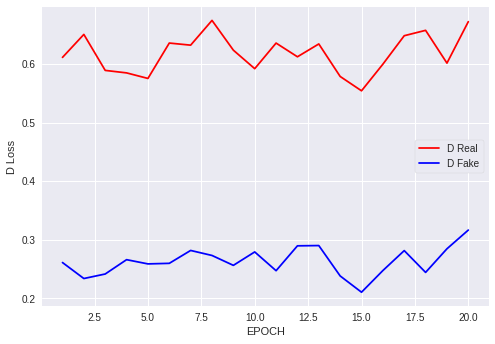

In [12]:
D_r_mean = []
D_f_mean = []

N = len(D_r)
length = N // (EPOCH)

for k in range(0,EPOCH):
  D_r_mean.append( np.mean(D_r[(k+1)*length -10 : (k+1)*length + 10] ))
  D_f_mean.append( np.mean(D_f[(k+1)*length -10 : (k+1)*length + 10] ))

print("Average D real loss")  
print(D_r_mean)
print("Average D fake loss")
print(D_f_mean)

index = np.arange(1,EPOCH+1,1)
f_d = plt.figure(1)
plt.plot(index, D_r_mean, 'r',label='D Real')
plt.plot(index, D_f_mean, 'b',label='D Fake')
plt.ylabel("D Loss")
plt.xlabel("EPOCH")
plt.legend(framealpha=1, frameon=True)
plt.show()


f_d.savefig('Real and fake Loss.png', dpi=600)

files.download('Real and fake Loss.png')

## Plot loss

Average D loss
[0.8753274, 0.7545825, 0.9339137, 1.0064814, 1.0097498, 0.822755, 0.9321219, 0.7622112, 0.8681854, 1.0316948, 0.8052949, 0.9875237, 0.90757483, 0.9504061, 0.95082915, 0.9013006, 0.86372834, 0.76692235, 1.086581, 0.8737558]
Average G loss
[1.5216542, 1.5928601, 1.6921208, 1.6420473, 1.6956627, 1.5057422, 1.553818, 1.4169589, 1.5873225, 1.614451, 1.5550375, 1.530342, 1.4578869, 1.7069432, 1.8458618, 1.6338545, 1.4870266, 1.5901834, 1.6885693, 1.3255904]


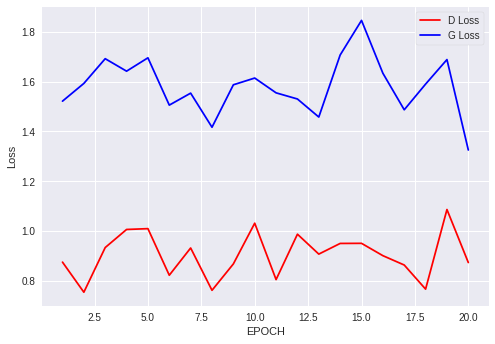

In [13]:
d_s_mean = []
g_s_mean = []

N = len(D_loss)
length = N // (EPOCH)

for k in range(0,EPOCH):
  d_s_mean.append( np.mean(D_loss[(k+1)*length -10 : (k+1)*length + 10] ))
  g_s_mean.append( np.mean(G_loss[(k+1)*length -10 : (k+1)*length + 10] ))

print("Average D loss")  
print(d_s_mean)
print("Average G loss")
print(g_s_mean)

index = np.arange(1,EPOCH+1,1)
f = plt.figure(1)
plt.plot(index, d_s_mean, 'r',label='D Loss')
plt.plot(index, g_s_mean, 'b',label='G Loss')
plt.ylabel("Loss")
plt.xlabel("EPOCH")
plt.legend(framealpha=1, frameon=True)
plt.show()

f.savefig('Loss.png', dpi=600)

files.download('Loss.png')

## Visualization

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./lenet


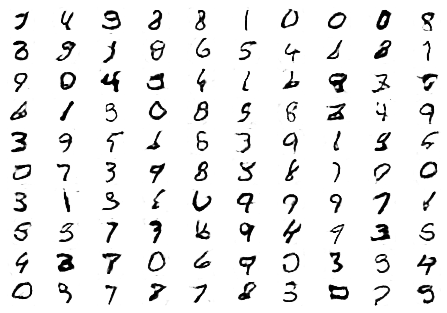

In [14]:
def plot_images(images,save = True):
    assert len(images) == 100
    img_shape = (28, 28)
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(10, 10)
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')
                # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()
    
    if save:    
        fig.savefig('G images_white.png', dpi=600)
        files.download('G images_white.png') 
     
n = np.random.normal(0.0, 1.0, [100,1,1,100]).astype(np.float32) 

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))    
    images = sess.run(G_noise, {noise: n, Training: False})   
plot_images(images) 
